### Load packages and churn data

In [1]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm, tqdm_notebook

import funCleaning, funEDA

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# display all columns of df
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 80

In [2]:
churnData = pd.read_csv('churnDataWithDistances.csv', low_memory=False)

### Have a first look at data

In [3]:
churnData.head()

,car_nr,ref_dt,target_event,NUM_CONSEC_SERVICES,SUM_INVOICE_AMOUNT_IN_SERVICE,SUM_INVOICE_AMOUNT,NUM_EVENTS,FIRST_EVT,LAST_EVT,LAST_MILEAGE,MEAN_MILEAGE_PER_MNTH,AVG_DIFF_MNTH,age_mnth,KANTON_LICENCE_PLATE,INSPECTION_INTERVAL_UID,LIST_PRICE,END_CUSTOMER_STATUS_UID,ACCIDENT_CAR,CAR_BRAND_UID,DESCRIPTION_DE,DESCRIPTION_DE2,FUEL_TYPE_UID,GEAR_TYPE_UID,WHEEL_DRIVE_UID,NUMBER_OF_DOORS_UID,GEAR_COUNT,EXTERIOR_COLOR_DE,INTERIOR_COLOR_DE,BASE_MARGIN,BUDGET_TYPE_IMPORT,SALES_TYPE,SALES_TYPE_IMPORT,CAR_OWNER_JOIN_NR,FUNCTION_TYPE_UID,PERSON_LANGUAGE_UID,TITLE,POSITION,EVT_BIRTH,PERSON_STREET,PERSON_STATE,PERSON_ZIP_CODE,PERSON_CITY,PERSON_ADRESS_COUNT,ownerAge,PARTNER_COMPANY_NR,NAME,ACTIVE,REGION_UID,SECTOR_UID,PARTNER_LANGUAGE_UID,IS_RETAIL_PARTNER,IS_PREFERRED_PARTNER,IS_DEALER,IS_SERVICE_PARTNER,RATING_UID,PARTNER_ADRESS_TYPE_UID,PARTNER_STREET,PARTNER_STATE,PARTNER_ZIP_CODE,PARTNER_CITY,PARTNER_ADRESS_COUNT,Sprachregion,Haushaltstyp,Urbanitaet,Wohneigentumverhaeltnis,Haushaltsgroesse,KaufkraftindexGemeinde,Fahrzeugtyp,Haushaltseinkommen,Fahrzeugklasse,Lebensphase,HaushaltsgroesseFein,Fahrzeugart,Altersklasse5J,Kanton,WEMFWirtschaftsgebiet,Altersklasse1J,PARTNER_LAT,PARTNER_LNG,PARTNER_ADDRESS,dist_metres,dist_seconds
0,13845534.0,2015-09-13 00:00:00.0000000,CHURN,1,0.0,286.45,8,2009-02-23 00:00:00.0000000,2014-04-08 00:00:00.0000000,79790.0,1286.935484,7,79,SH,24 Monate,21300.0,26 KMU Privatkunde,0,VW-PW,Polo Y&F 1.2 70PS 5G,9N31W4S5: Polo Young&Fresh 1.2 70 PS (2009),Benzin,Schaltgetriebe,Frontantrieb,5.0,5.0,Schwarz,Stoff Maxima anthrazit,9.0,POLIM,Polo,POLIM,92032419.0,NaN,Deutsch,NaN,NaN,NaN,Felsenstieg 9,SH,8200,Schaffhausen,2.0,22.0,13788514,NaN,1,Ostschweiz,"45 Motorfahrzeuge Handel, Instandhaltung & Rep...",Deutsch,1,0,1,1,NaN,Referenzadresse Postfach,Spitalstrasse 27,SH,8200,Schaffhausen,1,1,1,1,1,1.0,4.0,0,0.0,0,2,1.0,0.0,1.0,14.0,42.0,24.0,47.699836,8.633246,"Spitalstrasse 27, 8200 Schaffhausen, Switzerland",2805.0,302.0
1,13845535.0,2015-12-02 00:00:00.0000000,ACTIVE,5,0.0,0.00,10,2009-02-24 00:00:00.0000000,2014-08-04 00:00:00.0000000,48670.0,737.424242,6,82,SH,24 Monate,21300.0,26 KMU Privatkunde,0,VW-PW,Polo Y&F 1.2 70PS 5G,9N31W4S5: Polo Young&Fresh 1.2 70 PS (2009),Benzin,Schaltgetriebe,Frontantrieb,5.0,5.0,Schwarz,Stoff Maxima anthrazit,9.0,POLIM,Polo,POLIM,8953577.0,NaN,Deutsch,NaN,NaN,NaN,Talstrasse 60,SH,8200,Schaffhausen,2.0,56.0,13788514,NaN,1,Ostschweiz,"45 Motorfahrzeuge Handel, Instandhaltung & Rep...",Deutsch,1,0,1,1,NaN,Referenzadresse Postfach,Spitalstrasse 27,SH,8200,Schaffhausen,1,1,2,1,1,2.0,4.0,4,2.0,4,6,2.0,6.0,8.0,14.0,42.0,58.0,47.699836,8.633246,"Spitalstrasse 27, 8200 Schaffhausen, Switzerland",2805.0,302.0
2,13845526.0,2016-04-06 00:00:00.0000000,CHURN,1,0.0,0.00,5,2009-02-23 00:00:00.0000000,2014-06-06 00:00:00.0000000,53000.0,828.125000,12,86,SH,12 Monate,21300.0,26 KMU Privatkunde,0,VW-PW,Polo Y&F 1.2 70PS 5G,9N31W4S5: Polo Young&Fresh 1.2 70 PS (2009),Benzin,Schaltgetriebe,Frontantrieb,5.0,5.0,Schwarz,Stoff Maxima anthrazit,9.0,POLIM,Polo,POLIM,534584019.0,NaN,Deutsch,NaN,NaN,NaN,Otterngutstrasse 22,SH,8200,Schaffhausen,1.0,NaN,13788514,NaN,1,Ostschweiz,"45 Motorfahrzeuge Handel, Instandhaltung & Rep...",Deutsch,1,0,1,1,NaN,Referenzadresse Postfach,Spitalstrasse 27,SH,8200,Schaffhausen,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.699836,8.633246,"Spitalstrasse 27, 8200 Schaffhausen, Switzerland",2805.0,302.0
3,13845518.0,2016-08-08 00:00:00.0000000,CHURN,1,0.0,0.00,6,2009-02-26 00:00:00.0000000,2014-10-13 00:00:00.0000000,49000.0,720.588235,11,90,SH,24 Monate,21300.0,26 KMU Privatkunde,0,VW-PW,Polo Y&F 1.2 70PS 5G,9N31W4S5: Polo Young&Fresh 1.2 70 PS (2009),Benzin,Schaltgetriebe,Frontantrieb,5.0,5.0,Schwarz,Stoff Maxima anthrazit,9.0,POLIM,Polo,POLIM,290519342.0,NaN,Deutsch,NaN,NaN,NaN,Felsenaustrasse 20,SH,8200,Schaffhausen,1.0,25.0,13788514,NaN,1,Ostschweiz,"45 Motorfahrzeuge Handel, Instandhaltung & Rep...",Deutsch,1,0,1,1,NaN,Referenzadresse Postfach,Spitalstras

In [4]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56778 entries, 0 to 56777
Data columns (total 82 columns):
car_nr                           56778 non-null float64
ref_dt                           56778 non-null object
target_event                     56778 non-null object
NUM_CONSEC_SERVICES              56778 non-null int64
SUM_INVOICE_AMOUNT_IN_SERVICE    56778 non-null float64
SUM_INVOICE_AMOUNT               56778 non-null float64
NUM_EVENTS                       56778 non-null int64
FIRST_EVT                        56778 non-null object
LAST_EVT                         56778 non-null object
LAST_MILEAGE                     56777 non-null float64
MEAN_MILEAGE_PER_MNTH            56778 non-null float64
AVG_DIFF_MNTH                    56778 non-null int64
age_mnth                         56778 non-null int64
KANTON_LICENCE_PLATE             55490 non-null object
INSPECTION_INTERVAL_UID          56778 non-null object
LIST_PRICE                       56777 non-null float64
END_CUSTO

## Create training and test sets (with stratified sampling)

All exploration will only be performed on the training set. The test data is put aside from the very beginning to prevent 'data snooping bias'.

In [5]:
# print distribution of target labels
tDistr = churnData['target_event'].value_counts() / len(churnData)
print("ACTIVE in % of total: {:4.2f}".format(tDistr[0]))
print("CHURN in % of total: {:4.2f}".format(tDistr[1]))

ACTIVE in % of total: 0.65
CHURN in % of total: 0.35


In [6]:
# create testset with stratified sampling according to the target labels
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 111)
for train_index, test_index in split.split(churnData, churnData['target_event']):
    churnTrainSet = churnData.loc[train_index]
    churnTestSet = churnData.loc[test_index]
    
assert len(churnTestSet) == round(len(churnData) * 0.2)

In [7]:
# save training and test sets to csv for later use
churnTrainSet.to_csv('churnTrainSet.csv', index=False)
churnTestSet.to_csv('churnTestSet.csv', index=False)

### Make a copy of the training set

In [8]:
churn = churnTrainSet.copy()

## Initial Cleaning
1. Delete useless columns and fix columns dtypes
2. Clean numerical variables
3. Clean categorical variables
4. Clean object variables
5. Fix some NaN values 

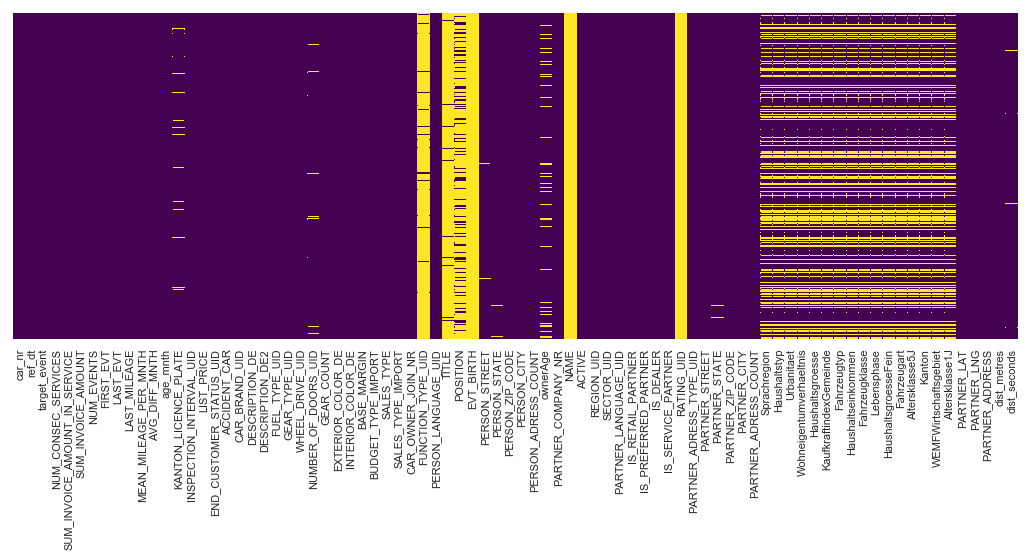

In [9]:
# heatmap of NaNs
plt.figure(figsize=(18,6))
sns.heatmap(churn.isnull(),yticklabels=False,cbar=False,cmap='viridis');

#### Eliminate cols that are definitively of no use for our model

- car_nr --> internal car id, of no use for modelling
- ref_dt --> a column that was constructed to set the target labels, would not be available in live data
- ACCIDENT_CAR --> only 20 accident cars in data set
- DESCRIPTION_DE --> detailed description of same content as SALES TYPE
- DESCRIPTION_DE2 --> even more detailed description of same content as SALES TYPE
- BUDGET TYPE IMPORT --> cryptic abrevations of same content as SALES TYPE
- SALES TYPE IMPORT --> cryptic abrevations of same content as SALES TYPE
- CAR OWNER JOIN NUMBER --> internal customer id, of no use for modelling
- FUNCTION TYPE UID --> to many NaN
- TITLE --> too many NaN
- POSITION --> too many NaN
- EVT BIRTH --> all NaN (anonymization of data)
- PERSON_STREET --> we have distances to partner                                     
- PERSON_ZIP_CODE --> we have the distances to partner
- PERSON_CITY --> we have the distances to partner, and the states
- NAME --> all NaN (anonymization of data)
- PARTNER_COMPANY_NR --> internal ID, of no use for modelling 
- SECTOR UID --> same entry in nearly all rows, should be the same, differences are irrelevant
- IS RETAIL PARTNER --> same as in ACTIVE
- IS SERVICE PARTNER --> same as in ACTIVE
- RATING UID --> all NaN
- PARTNER_STREET --> we have distances to partner
- PARTNER_ZIP_CODE --> we still have the city as highly correlated variable
- PARTNER_ADRESS_TYPE_UID --> can be interfered from partner street (and is certainly not relevant)
- Altersklasse5J --> many NaN, we have better age data in the set
- Kanton --> many NaN, we have better state data in the set
- WEMFWirtschaftsgebiet --> we have better regional data in the set
- Sprachregion --> we have better data concerning customer languages in the set
- (Altersklasse1J --> redundant with ownerAge, but could still help with quality issues in next steps - we'll delete later)
- PARTNER_LAT, PARTNER_LNG, PARTNER_ADDRESS --> were used to get distance data

In [10]:
colsToDel = ['car_nr', 'ref_dt', 'ACCIDENT_CAR', 'DESCRIPTION_DE', 'DESCRIPTION_DE2', 'BUDGET_TYPE_IMPORT', 'SALES_TYPE_IMPORT', 
             'FUNCTION_TYPE_UID', 'TITLE', 'POSITION', 'EVT_BIRTH', 'NAME', 'PERSON_CITY', 'SECTOR_UID', 'IS_RETAIL_PARTNER', 
             'IS_SERVICE_PARTNER', 'RATING_UID', 'PARTNER_ADRESS_TYPE_UID', 'Altersklasse5J', 'Kanton', 'CAR_OWNER_JOIN_NR',
             'WEMFWirtschaftsgebiet', 'PERSON_STREET', 'PERSON_ZIP_CODE', 'PARTNER_STREET', 'PARTNER_ZIP_CODE', 'PARTNER_LAT',
             'PARTNER_LNG', 'PARTNER_ADDRESS', 'PARTNER_COMPANY_NR', 'Sprachregion']

churn = funCleaning.delCols(churn, colsToDel=colsToDel)

'car_nr successfully deleted'

'ref_dt successfully deleted'

'ACCIDENT_CAR successfully deleted'

'DESCRIPTION_DE successfully deleted'

'DESCRIPTION_DE2 successfully deleted'

'BUDGET_TYPE_IMPORT successfully deleted'

'SALES_TYPE_IMPORT successfully deleted'

'FUNCTION_TYPE_UID successfully deleted'

'TITLE successfully deleted'

'POSITION successfully deleted'

'EVT_BIRTH successfully deleted'

'NAME successfully deleted'

'PERSON_CITY successfully deleted'

'SECTOR_UID successfully deleted'

'IS_RETAIL_PARTNER successfully deleted'

'IS_SERVICE_PARTNER successfully deleted'

'RATING_UID successfully deleted'

'PARTNER_ADRESS_TYPE_UID successfully deleted'

'Altersklasse5J successfully deleted'

'Kanton successfully deleted'

'CAR_OWNER_JOIN_NR successfully deleted'

'WEMFWirtschaftsgebiet successfully deleted'

'PERSON_STREET successfully deleted'

'PERSON_ZIP_CODE successfully deleted'

'PARTNER_STREET successfully deleted'

'PARTNER_ZIP_CODE successfully deleted'

'PARTNER_LAT successfully deleted'

'PARTNER_LNG successfully deleted'

'PARTNER_ADDRESS successfully deleted'

'PARTNER_COMPANY_NR successfully deleted'

'Sprachregion successfully deleted'

#### Fix selected datatypes

In [11]:
colsToDt = ['FIRST_EVT', 'LAST_EVT']
colsToCat = ['target_event', 'CAR_BRAND_UID', 'GEAR_TYPE_UID', 'FUEL_TYPE_UID','WHEEL_DRIVE_UID', 'PERSON_LANGUAGE_UID', 
            'PARTNER_LANGUAGE_UID', 'ACTIVE', 'IS_PREFERRED_PARTNER', 'IS_DEALER', 'PARTNER_CITY', 'KANTON_LICENCE_PLATE', 
            'BASE_MARGIN', 'GEAR_COUNT', 'PERSON_ADRESS_COUNT', 'NUMBER_OF_DOORS_UID', 'PARTNER_ADRESS_COUNT', 'PARTNER_STATE',
            'INSPECTION_INTERVAL_UID', 'END_CUSTOMER_STATUS_UID', 'PERSON_STATE', 'REGION_UID'] + list(churn.columns[-14:-3])

churn = funCleaning.fixDtypes(churn, colsToCat=colsToCat, colsToDt=colsToDt, dtPattern="%Y/%m/%d")

In [12]:
# check
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45422 entries, 10483 to 17388
Data columns (total 51 columns):
target_event                     45422 non-null category
NUM_CONSEC_SERVICES              45422 non-null int64
SUM_INVOICE_AMOUNT_IN_SERVICE    45422 non-null float64
SUM_INVOICE_AMOUNT               45422 non-null float64
NUM_EVENTS                       45422 non-null int64
FIRST_EVT                        45422 non-null datetime64[ns]
LAST_EVT                         45422 non-null datetime64[ns]
LAST_MILEAGE                     45422 non-null float64
MEAN_MILEAGE_PER_MNTH            45422 non-null float64
AVG_DIFF_MNTH                    45422 non-null int64
age_mnth                         45422 non-null int64
KANTON_LICENCE_PLATE             44365 non-null category
INSPECTION_INTERVAL_UID          45422 non-null category
LIST_PRICE                       45421 non-null float64
END_CUSTOMER_STATUS_UID          45421 non-null category
CAR_BRAND_UID                    4542

### Numerical Variables

In [13]:
churn.describe()

,NUM_CONSEC_SERVICES,SUM_INVOICE_AMOUNT_IN_SERVICE,SUM_INVOICE_AMOUNT,NUM_EVENTS,LAST_MILEAGE,MEAN_MILEAGE_PER_MNTH,AVG_DIFF_MNTH,age_mnth,LIST_PRICE,ownerAge,Altersklasse1J,dist_metres,dist_seconds
count,45422.000000,45422.000000,45422.000000,45422.000000,4.542200e+04,4.542200e+04,45422.000000,45422.000000,45421.000000,41340.000000,30744.000000,45422.000000,44941.000000
mean,2.276188,43.128110,1174.288970,11.349654,6.227991e+04,1.317959e+03,4.166549,58.572608,48485.317827,49.685486,50.833886,28562.390670,1572.547140
std,1.461800,481.706746,1781.347297,6.572171,6.456237e+05,7.223337e+03,1.960246,23.178563,24814.245619,15.303883,18.035702,53075.773309,2102.752086
min,1.000000,0.000000,0.000000,3.000000,1.200000e+01,9.230769e-01,0.000000,7.000000,9920.000000,0.000000,0.000000,79.000000,112.000000
25%,1.000000,0.000000,0.000000,6.000000,2.957900e+04,8.108108e+02,3.000000,42.000000,31490.000000,38.000000,41.000000,4771.500000,562.000000
50%,2.000000,0.000000,552.675000,10.000000,4.870950e+04,1.153367e+03,4.000000,54.000000,43030.000000,49.000000,52.000000,10389.000000,923.000000
75%,3.000000,0.000000,1545.850000,14.000000,7.691825e+04,1.572931e+03,5.000000,73.000000,58830.000000,60.000000,63.000000,25327.000000,1602.000000
max,14.000000,79601.000000,79601.000000,80.000000,1.369870e+08,1.522078e+06,31.000000,516.000000,320950.000000,364.000000,99.000000,806350.000000,30069.000000


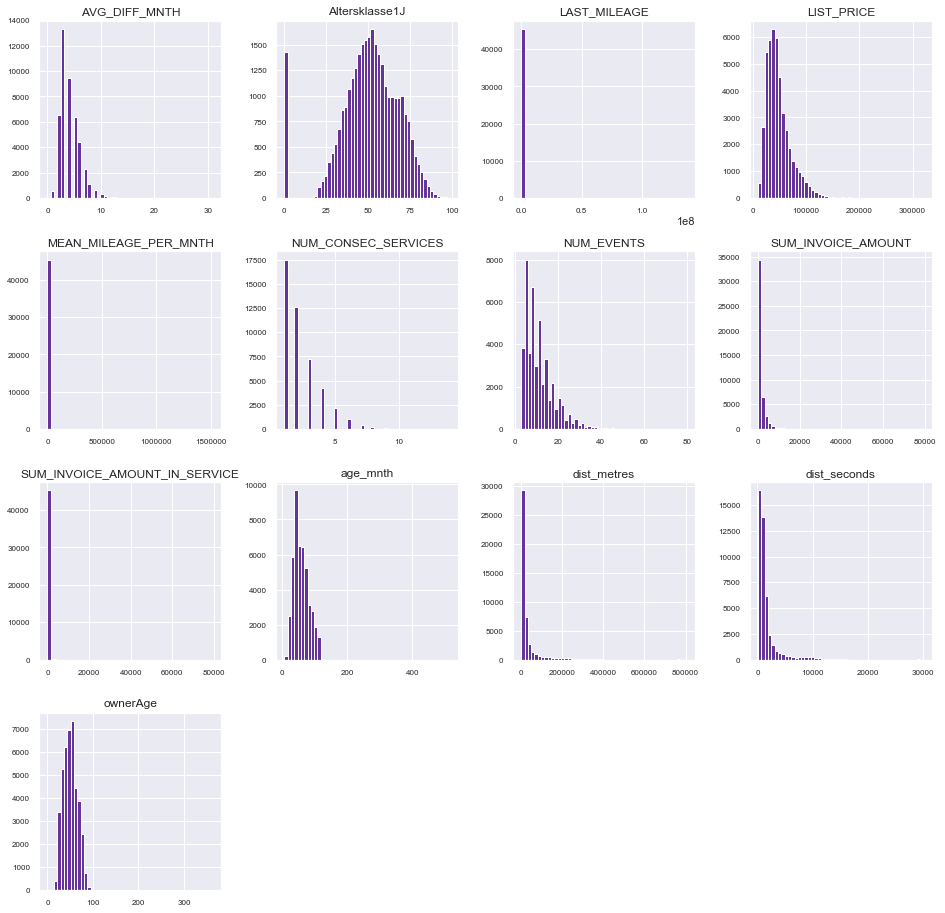

In [14]:
funEDA.histDF(churn);

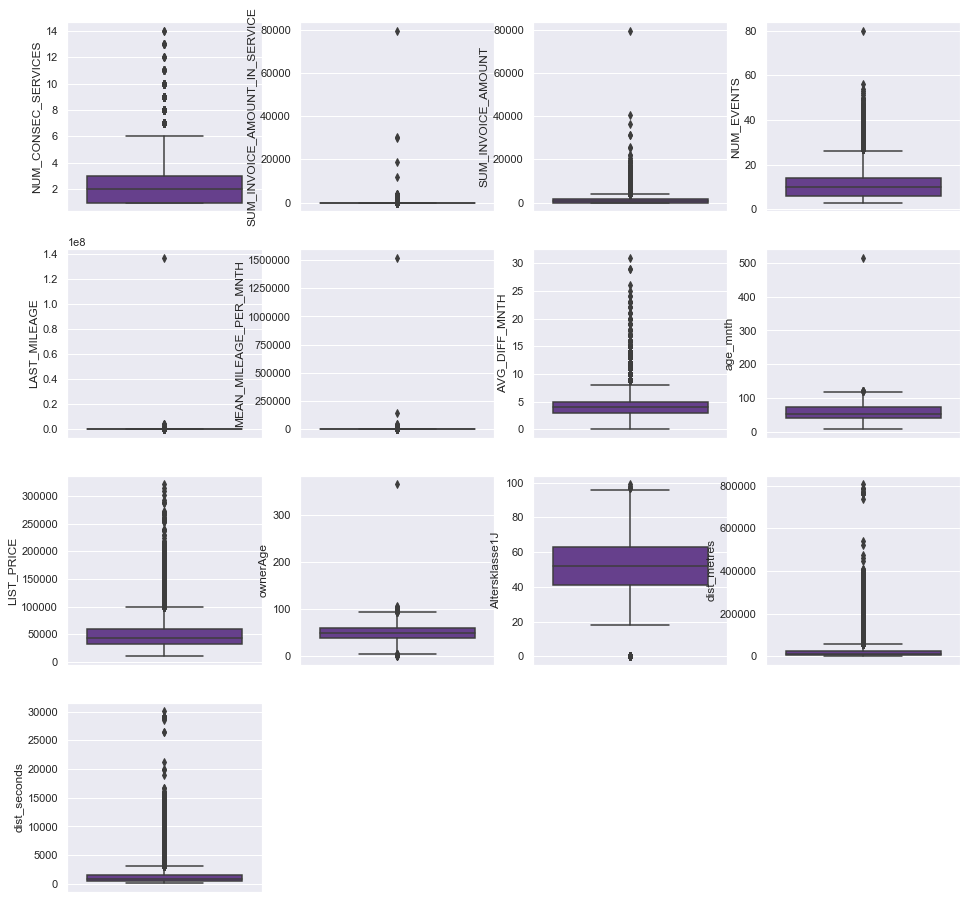

In [15]:
funEDA.boxplotDF(churn);

In [16]:
# check for values with most occurences
for col in churn.select_dtypes(include = ['float64', 'int64']):
    display(churn[col].value_counts().head())

1    17515
2    12611
3     7274
4     4180
5     2132
Name: NUM_CONSEC_SERVICES, dtype: int64

0.0       42530
1.0         266
500.0        81
450.0        54
1000.0       42
Name: SUM_INVOICE_AMOUNT_IN_SERVICE, dtype: int64

0.00      12669
1.00         61
110.65       51
166.65       41
114.70       40
Name: SUM_INVOICE_AMOUNT, dtype: int64

5    4126
6    3877
4    3757
7    3571
8    3462
Name: NUM_EVENTS, dtype: int64

60000.0    65
30000.0    57
50000.0    46
45000.0    45
40000.0    44
Name: LAST_MILEAGE, dtype: int64

1250.000000    21
1000.000000    19
2000.000000    16
1500.000000    15
833.333333     14
Name: MEAN_MILEAGE_PER_MNTH, dtype: int64

3    13303
4     9413
2     6544
5     6398
6     4425
Name: AVG_DIFF_MNTH, dtype: int64

47    1660
46    1567
48    1124
45    1116
34    1060
Name: age_mnth, dtype: int64

23350.0    51
44900.0    37
31280.0    36
27800.0    34
23270.0    33
Name: LIST_PRICE, dtype: int64

51.0    1064
49.0    1029
46.0    1023
53.0    1021
52.0    1010
Name: ownerAge, dtype: int64

0.0     1426
52.0     860
51.0     821
53.0     793
54.0     788
Name: Altersklasse1J, dtype: int64

7587.0     375
1945.0     233
14221.0    229
2188.0     196
2288.0     183
Name: dist_metres, dtype: int64

563.0     319
342.0     314
1341.0    224
166.0     218
297.0     198
Name: dist_seconds, dtype: int64

**Need for cleaning:**

- SUM_INVOICE_AMOUNT_IN_SERVICE: has so many rows with value 0 (> 55'000), that column has to be deleted
- age_mnth: cars older than 8 years are not in acquisition focus of the company and can be dropped
- ownerAge: there sould be no car owners < 18 years --> replace with external Data ('Altersklasse1J') where > 90, <18 if possible, set all age = 0 to NaN
- SUM_INVOICE_AMOUNT: values = 0 will be set to NaN
- Jahresklasse1J: will be used for cleaning ownerAge where possible and column will then be deleted
- dist_seconds: drop column, in first iteration I have seen that it is highly correlated with dist_metres (>0.95) but has more outliers / NaN that would be removed unecessarily

Separate operation: log10 transformation for skewed columns

Separate operation: Outlier removal according to IQR-rule (distance from 1th / 3rd quartile > 1.5 * IQR)

In [17]:
# %%writefile funChurn.py

def funCleanNumericals(df):
    df['SUM_INVOICE_AMOUNT'].replace(0.0, np.NaN, inplace=True)
    # replacing ownerAge where implausible with Altersklasse 1J, setting age 0 to NaN
    df['ownerAge'] = np.where((df['ownerAge'] >= 90) | (df['ownerAge'] < 18) | (df['ownerAge'].isnull()), 
                              df['Altersklasse1J'], df['ownerAge'])
    df['ownerAge'].replace(0.0, np.NaN, inplace=True)
    df = df[df['age_mnth'] <= 96]
    return df

In [18]:
for col in ['SUM_INVOICE_AMOUNT_IN_SERVICE', 'Altersklasse1J', 'dist_seconds']:
    colsToDel.append(col)

churn = funCleanNumericals(churn)
churn = funCleaning.delCols(churn, colsToDel=colsToDel)

'SUM_INVOICE_AMOUNT_IN_SERVICE successfully deleted'

'Altersklasse1J successfully deleted'

'dist_seconds successfully deleted'

In [19]:
# perform log10 transformation for skewed columns
colsToLog10=['LAST_MILEAGE', 'NUM_EVENTS', 'SUM_INVOICE_AMOUNT', 'dist_metres', 'LIST_PRICE']
churn = funCleaning.colsToLog10(churn, colsToLog10=colsToLog10)

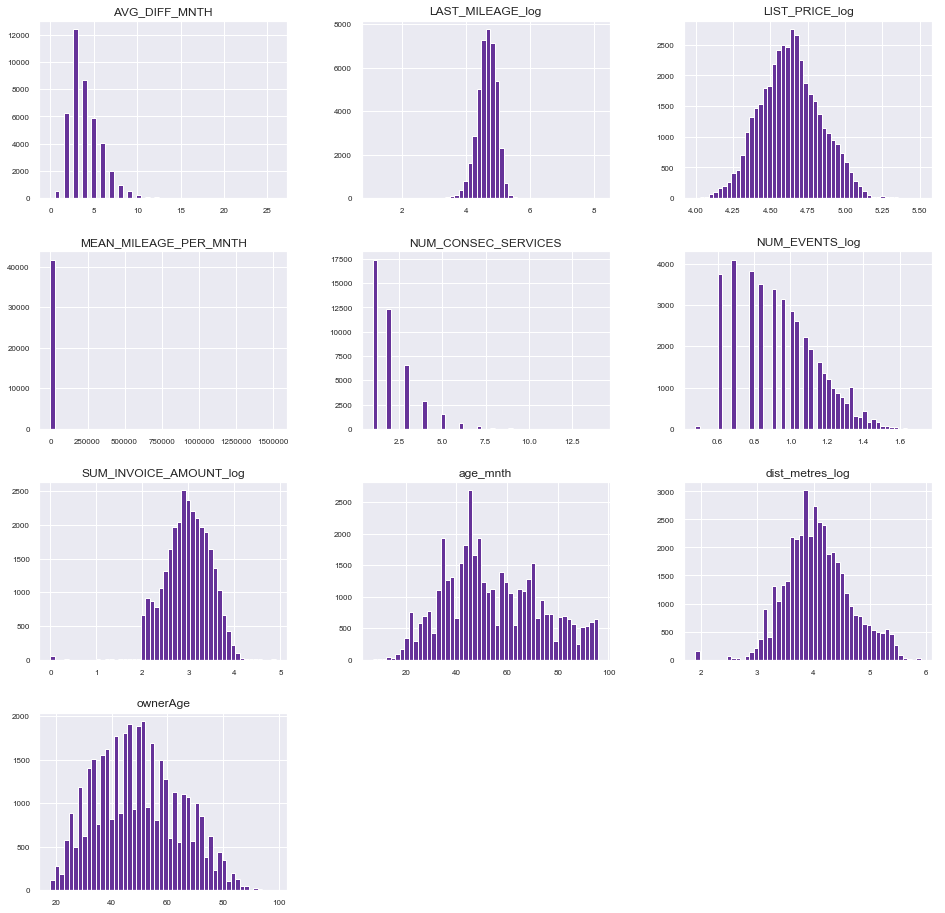

In [20]:
# check
funEDA.histDF(churn);

In [21]:
# analyze outliers
funCleaning.outlierDetectionIQR(churn)

NUM_CONSEC_SERVICES
Identified outliers: 378
Percentage of outliers: 0.9%

SUM_INVOICE_AMOUNT_log
Identified outliers: 75
Percentage of outliers: 0.2%

NUM_EVENTS_log
Identified outliers: 19
Percentage of outliers: 0.0%

LAST_MILEAGE_log
Identified outliers: 671
Percentage of outliers: 1.6%

MEAN_MILEAGE_PER_MNTH
Identified outliers: 1354
Percentage of outliers: 3.2%

AVG_DIFF_MNTH
Identified outliers: 958
Percentage of outliers: 2.3%

age_mnth
Identified outliers: 0
Percentage of outliers: 0.0%

LIST_PRICE_log
Identified outliers: 206
Percentage of outliers: 0.5%

ownerAge
Identified outliers: 13
Percentage of outliers: 0.0%

dist_metres_log
Identified outliers: 390
Percentage of outliers: 0.9%



In [22]:
# remove outliers
churn = funCleaning.outlierRemovalIQR(churn)

NUM_CONSEC_SERVICES
Outliers removed: 378

SUM_INVOICE_AMOUNT_log
Outliers removed: 74

NUM_EVENTS_log
Outliers removed: 11

LAST_MILEAGE_log
Outliers removed: 673

MEAN_MILEAGE_PER_MNTH
Outliers removed: 1236

AVG_DIFF_MNTH
Outliers removed: 946

age_mnth
Outliers removed: 0

LIST_PRICE_log
Outliers removed: 195

ownerAge
Outliers removed: 10

dist_metres_log
Outliers removed: 362



In [23]:
# check
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37862 entries, 10483 to 32271
Data columns (total 48 columns):
target_event               37862 non-null category
NUM_CONSEC_SERVICES        37862 non-null int64
SUM_INVOICE_AMOUNT_log     27264 non-null float64
NUM_EVENTS_log             37862 non-null float64
FIRST_EVT                  37862 non-null datetime64[ns]
LAST_EVT                   37862 non-null datetime64[ns]
LAST_MILEAGE_log           37862 non-null float64
MEAN_MILEAGE_PER_MNTH      37862 non-null float64
AVG_DIFF_MNTH              37862 non-null int64
age_mnth                   37862 non-null int64
KANTON_LICENCE_PLATE       37013 non-null category
INSPECTION_INTERVAL_UID    37862 non-null category
LIST_PRICE_log             37861 non-null float64
END_CUSTOMER_STATUS_UID    37861 non-null category
CAR_BRAND_UID              37862 non-null category
FUEL_TYPE_UID              37861 non-null category
GEAR_TYPE_UID              37861 non-null category
WHEEL_DRIVE_UID       

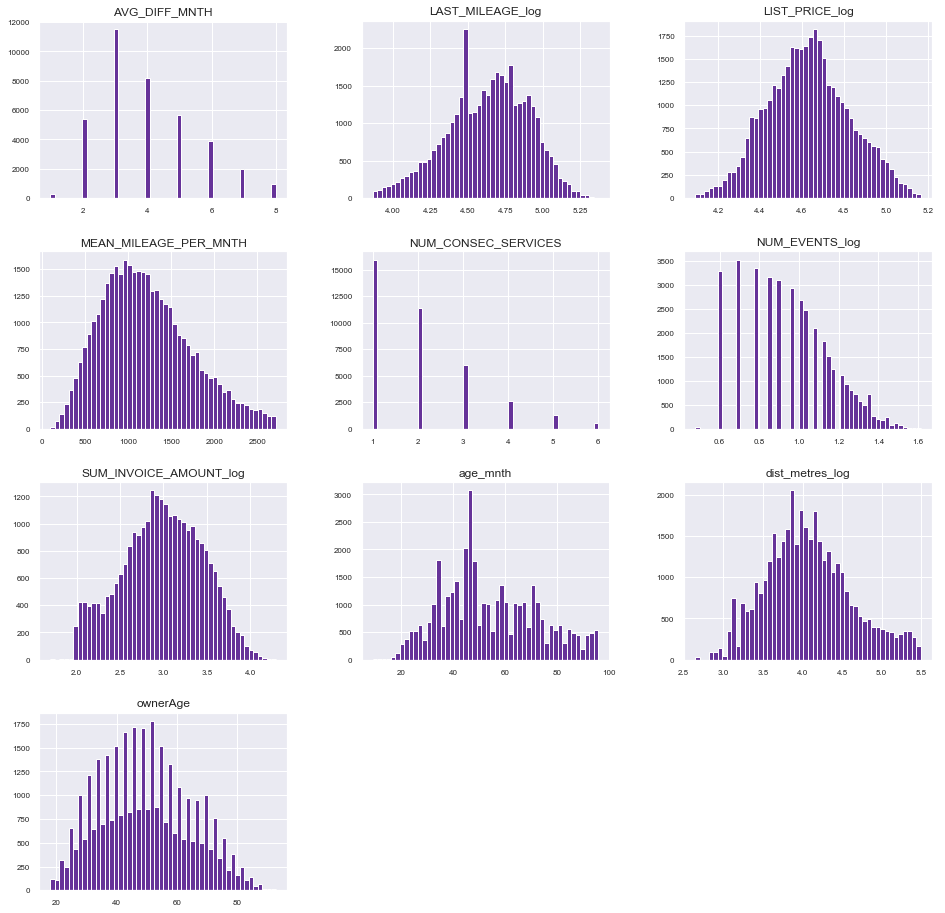

In [24]:
funEDA.histDF(churn);

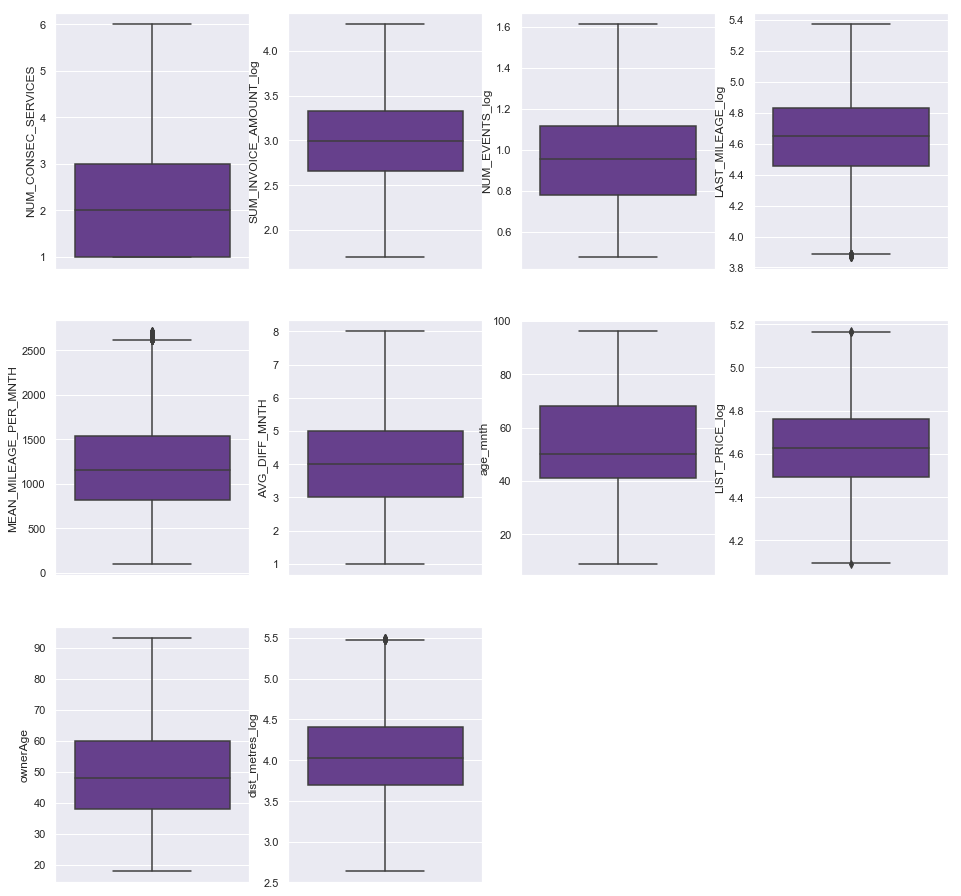

In [25]:
funEDA.boxplotDF(churn);

### Categorical Variables

In [26]:
churn.describe(include='category')

,target_event,KANTON_LICENCE_PLATE,INSPECTION_INTERVAL_UID,END_CUSTOMER_STATUS_UID,CAR_BRAND_UID,FUEL_TYPE_UID,GEAR_TYPE_UID,WHEEL_DRIVE_UID,NUMBER_OF_DOORS_UID,GEAR_COUNT,BASE_MARGIN,PERSON_LANGUAGE_UID,PERSON_STATE,PERSON_ADRESS_COUNT,ACTIVE,REGION_UID,PARTNER_LANGUAGE_UID,IS_PREFERRED_PARTNER,IS_DEALER,PARTNER_STATE,PARTNER_CITY,PARTNER_ADRESS_COUNT,Haushaltstyp,Urbanitaet,Wohneigentumverhaeltnis,Haushaltsgroesse,KaufkraftindexGemeinde,Fahrzeugtyp,Haushaltseinkommen,Fahrzeugklasse,Lebensphase,HaushaltsgroesseFein,Fahrzeugart
count,37862,37013,37862,37861,37862,37861,37861,37861,37086.0,37861.0,37862.0,37862,37477,37862.0,37862,37862,37862,37862,37862,37605,37862,37862,25706,25706,25706,25706.0,25706.0,25706,25706.0,25706,25706,25706.0,25705.0
unique,2,87,2,4,5,7,2,3,4.0,5.0,9.0,3,26,5.0,2,8,3,2,2,15,59,4,4,5,5,7.0,9.0,8,7.0,9,10,10.0,13.0
top,ACTIVE,ZH,24 Monate,03 Privatkunde,VW-PW,Benzin,Automat,Frontantrieb,5.0,6.0,7.0,Deutsch,ZH,2.0,1,Genferseeregion,Deutsch,0,1,ZH,Dübendorf,2,2,2,,2.0,4.0,4,3.0,0,4,2.0,6.0
freq,25626,7559,36774,26019,15922,26998,19439,24418,31313.0,18610.0,12312.0,23008,7806,24560.0,37748,9233,22676,28767,29737,7974,2394,21236,14322,13933,12208,7803.0,7937.0,12532,5841.0,8774,6400,7803.0,12532.0


"Not plotted: ['KANTON_LICENCE_PLATE', 'PARTNER_CITY']"

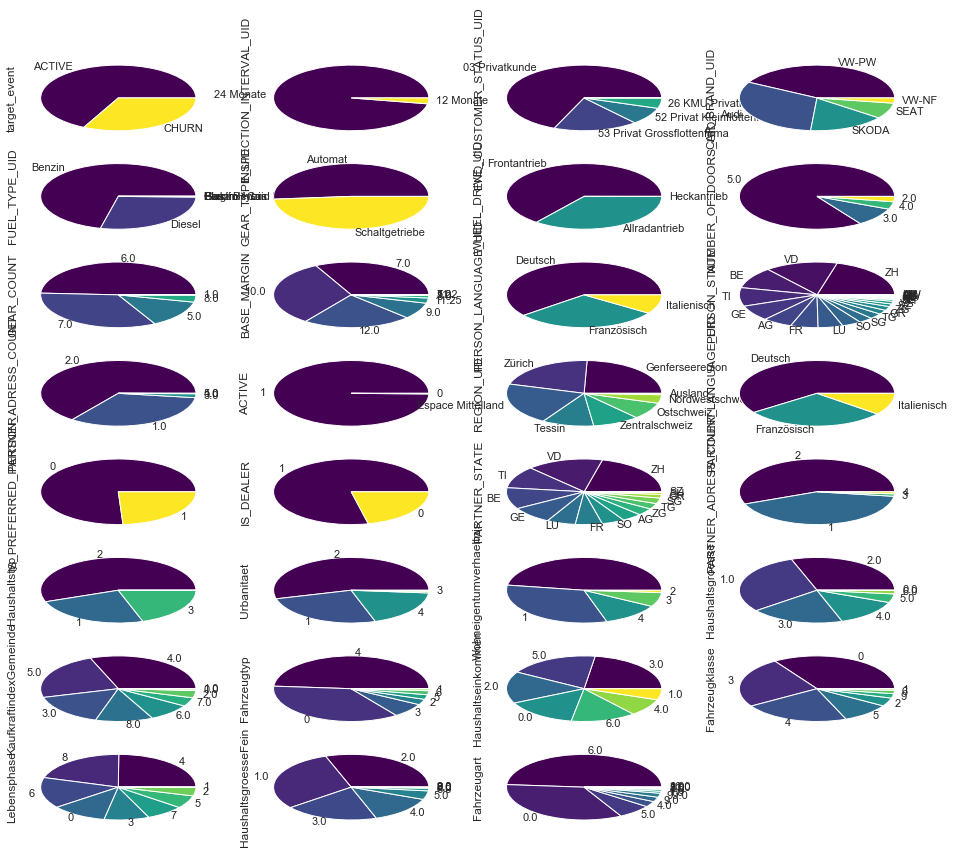

In [27]:
funEDA.pieDF(churn);

In [28]:
# check ACTIVE colums
display(len(churn[churn['ACTIVE'] == 0]))
display(churn.loc[(churn['ACTIVE'] == 0), 'PARTNER_CITY'].unique())

114

[Oberarth]
Categories (1, object): [Oberarth]

**Need for cleaning:**
    
- ACTIVE: 127 observations have status = 0, they belong to a closed partner and will be removed, column will be deleted.
- KANTON_LICENCE_PLATE: 158 values, only 27 are valid. 80% of entries are identical with PERSON_STATE. Column will be deleted.
- Set value 0 in last 12 columns to NaN
- Transform target value to numerical (for later correlation analysis)

In [29]:
# %%writefile -a funChurn.py

def funCleanCategoricals(df):
    df = df[df['ACTIVE'] == 1]
    df['target_event'] = df['target_event'].map({'ACTIVE':0, 'CHURN':1}).astype(np.int64)
    return df

In [30]:
for col in ['ACTIVE', 'KANTON_LICENCE_PLATE']:
    colsToDel.append(col)
    
pd.set_option('mode.chained_assignment', None) # disable warning

churn = funCleanCategoricals(churn)
churn = funCleaning.delCols(churn, colsToDel=colsToDel)

'ACTIVE successfully deleted'

'KANTON_LICENCE_PLATE successfully deleted'

In [31]:
# check
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37748 entries, 10483 to 32271
Data columns (total 46 columns):
target_event               37748 non-null int64
NUM_CONSEC_SERVICES        37748 non-null int64
SUM_INVOICE_AMOUNT_log     27191 non-null float64
NUM_EVENTS_log             37748 non-null float64
FIRST_EVT                  37748 non-null datetime64[ns]
LAST_EVT                   37748 non-null datetime64[ns]
LAST_MILEAGE_log           37748 non-null float64
MEAN_MILEAGE_PER_MNTH      37748 non-null float64
AVG_DIFF_MNTH              37748 non-null int64
age_mnth                   37748 non-null int64
INSPECTION_INTERVAL_UID    37748 non-null category
LIST_PRICE_log             37747 non-null float64
END_CUSTOMER_STATUS_UID    37747 non-null category
CAR_BRAND_UID              37748 non-null category
FUEL_TYPE_UID              37747 non-null category
GEAR_TYPE_UID              37747 non-null category
WHEEL_DRIVE_UID            37747 non-null category
NUMBER_OF_DOORS_UID      

### DateTime Variables

In [32]:
churn.describe(include='datetime')

,FIRST_EVT,LAST_EVT
count,37748,37748
unique,2137,1172
top,2012-11-30 00:00:00,2015-10-30 00:00:00
freq,298,159
first,2007-08-08 00:00:00,2013-10-01 00:00:00
last,2015-05-31 00:00:00,2017-09-25 00:00:00


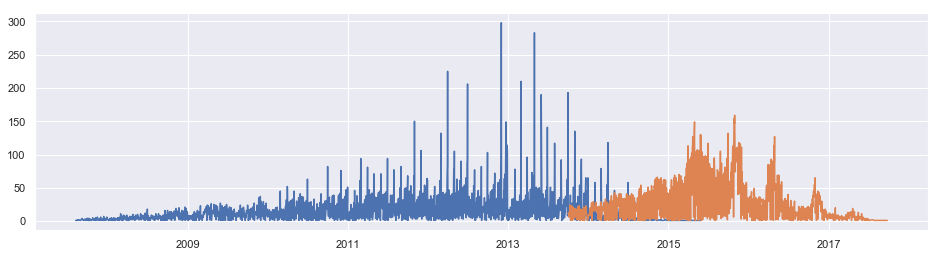

In [33]:
# visualize first and last events over time
churn_dt = churn.select_dtypes(include='datetime')
plt.figure(figsize=(16,4))
for col in churn_dt:
    churn_dt_grouped = churn_dt.groupby(col).count()
    plt.plot(churn_dt_grouped)

In [34]:
# create a new numerical variable 'duration_days'
churn['duration_days'] = churn['LAST_EVT'] - churn['FIRST_EVT']
churn['duration_days'] = churn['duration_days'].astype(str).str.split().str.get(0).astype(np.int64)

count    37748.000000
mean      1317.401770
std        579.746784
min        153.000000
25%        825.000000
50%       1256.000000
75%       1724.000000
max       2934.000000
Name: duration_days, dtype: float64

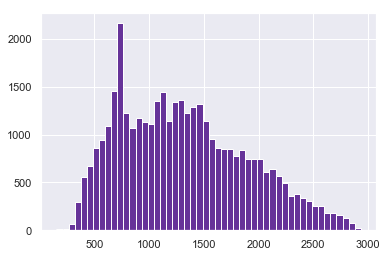

In [35]:
#check
display(churn['duration_days'].describe())
churn['duration_days'].hist(bins=50, color='rebeccapurple');

In [36]:
# drop datetime columns as they are no longer needed
for col in ['LAST_EVT', 'FIRST_EVT']:
    colsToDel.append(col)
    
churn = funCleaning.delCols(churn, colsToDel=colsToDel)

'LAST_EVT successfully deleted'

'FIRST_EVT successfully deleted'

### Object Variables

In [37]:
churn.describe(include='object')

,EXTERIOR_COLOR_DE,INTERIOR_COLOR_DE,SALES_TYPE
count,37746,37746,37748
unique,533,735,114
top,Deepblack Perleffekt,schwarz / Himmel silber,Golf
freq,3295,3038,4775


In [38]:
churn.select_dtypes(include = 'object').sample(5)

,EXTERIOR_COLOR_DE,INTERIOR_COLOR_DE,SALES_TYPE
12173,daytonagrau Perleffekt,schwarz-felsgrau,RS Q3
29107,aqua blau metallic,Stoff Reflex onyx,Yeti
50300,magic schwarz perleffekt,schwarz/Armaturenbrett onyx/on,Octavia Combi
31167,Candy White,Stoff titanschwarz,Golf Variant
25123,meteorgrau perleffekt,schwarz / Himmel schwarz,S3 Sportback


**Need for cleaning:**
- SALES_TYPE: shorten values and transform to category
- delete both Color Columns

In [39]:
# %%writefile -a funChurn.py

def funCleanStrings(df):
    df['SALES_TYPE'] = df['SALES_TYPE'].str.split(' ').str.get(0)
    df['SALES_TYPE'] = df['SALES_TYPE'].astype('category')
    return df

In [40]:
for col in ['EXTERIOR_COLOR_DE', 'INTERIOR_COLOR_DE']:
    colsToDel.append(col)

churn = funCleanStrings(churn)
churn = funCleaning.delCols(churn, colsToDel=colsToDel)

assert list(churn.select_dtypes(include = ['object']).columns) == []

'EXTERIOR_COLOR_DE successfully deleted'

'INTERIOR_COLOR_DE successfully deleted'

In [41]:
# check
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37748 entries, 10483 to 32271
Data columns (total 43 columns):
target_event               37748 non-null int64
NUM_CONSEC_SERVICES        37748 non-null int64
SUM_INVOICE_AMOUNT_log     27191 non-null float64
NUM_EVENTS_log             37748 non-null float64
LAST_MILEAGE_log           37748 non-null float64
MEAN_MILEAGE_PER_MNTH      37748 non-null float64
AVG_DIFF_MNTH              37748 non-null int64
age_mnth                   37748 non-null int64
INSPECTION_INTERVAL_UID    37748 non-null category
LIST_PRICE_log             37747 non-null float64
END_CUSTOMER_STATUS_UID    37747 non-null category
CAR_BRAND_UID              37748 non-null category
FUEL_TYPE_UID              37747 non-null category
GEAR_TYPE_UID              37747 non-null category
WHEEL_DRIVE_UID            37747 non-null category
NUMBER_OF_DOORS_UID        36972 non-null category
GEAR_COUNT                 37747 non-null category
BASE_MARGIN                37748 non-

### Fix missing state values for partners and customers

In [42]:
# look at missing partner states
churn.loc[(churn['PARTNER_STATE'].isnull()), 'PARTNER_CITY'].unique()

[Vaduz]
Categories (1, object): [Vaduz]

In [43]:
# look at missing customer customer states
display(churn['PERSON_STATE'].count())
churn.loc[(churn['PERSON_STATE'].isnull()), ['PARTNER_STATE', 'dist_metres']]

37363

C:\Users\r2d4\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,PARTNER_STATE,dist_metres
51693,NaN,NaN
13084,NaN,NaN
16681,BE,NaN
29913,FR,NaN
45130,SG,NaN
41641,LU,NaN
38715,NaN,NaN
20491,NaN,NaN
21777,SG,NaN
29194,GE,NaN


In [44]:
# check partner sates
display(churn['PARTNER_STATE'].count())
display(churn['PARTNER_STATE'].unique())

37491

[SO, VD, GE, TG, BE, ..., AG, FR, SH, SG, NaN]
Length: 15
Categories (14, object): [SO, VD, GE, TG, ..., AG, FR, SH, SG]

In [45]:
# check customer states
display(churn['PERSON_STATE'].count())
churn.loc[(churn['PERSON_STATE'].isnull()), ['PARTNER_STATE', 'dist_metres']]

37363

C:\Users\r2d4\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,PARTNER_STATE,dist_metres
51693,NaN,NaN
13084,NaN,NaN
16681,BE,NaN
29913,FR,NaN
45130,SG,NaN
41641,LU,NaN
38715,NaN,NaN
20491,NaN,NaN
21777,SG,NaN
29194,GE,NaN


In [46]:
# %%writefile -a funChurn.py

def funCleanMissingStates(df):
    # set missing partner states to "FL"
    df['PARTNER_STATE'] = np.where((df['PARTNER_STATE'].isnull()),"FL", df['PARTNER_STATE'])
    # set missing customer state = partner state where distance to partner < 20 km
    df['PERSON_STATE'] = np.where((df['PERSON_STATE'].isnull()) & (df['dist_metres_log'] <= np.log10(20000)),
                                                                      df['PARTNER_STATE'], df['PERSON_STATE'])
    df[['PARTNER_STATE', 'PERSON_STATE']] = df[['PARTNER_STATE', 'PERSON_STATE']].astype('category')
    return df

In [47]:
funCleanMissingStates(churn);

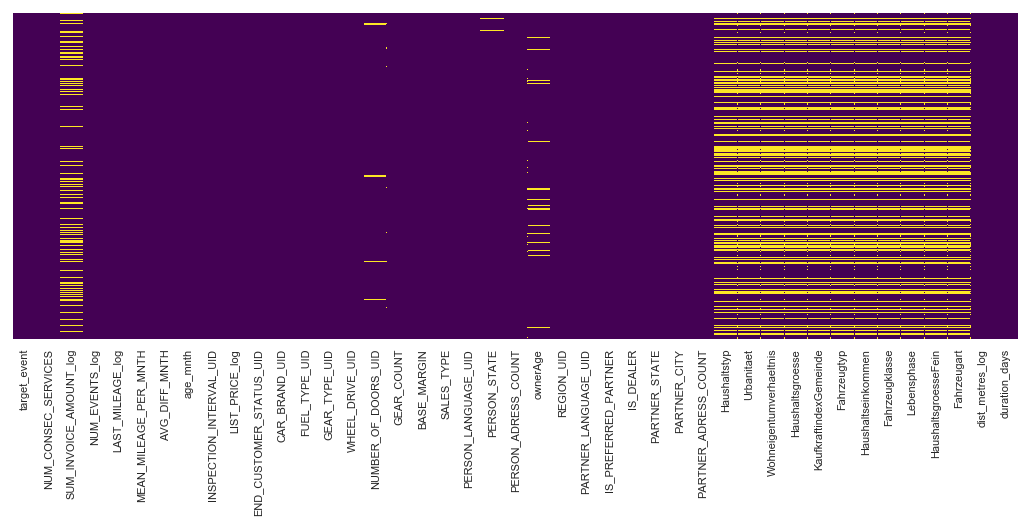

In [48]:
# heatmap of remaining NaNs
plt.figure(figsize=(18,6))
sns.heatmap(churn.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [49]:
# print number of NaNs for every column with NaNs
for col in churn:
    if churn[col].isnull().sum() > 0:
        print(churn[col].name +": "+str(churn[col].isnull().sum()))

SUM_INVOICE_AMOUNT_log: 10557
LIST_PRICE_log: 1
END_CUSTOMER_STATUS_UID: 1
FUEL_TYPE_UID: 1
GEAR_TYPE_UID: 1
WHEEL_DRIVE_UID: 1
NUMBER_OF_DOORS_UID: 776
GEAR_COUNT: 1
PERSON_STATE: 87
ownerAge: 2546
Haushaltstyp: 12125
Urbanitaet: 12125
Wohneigentumverhaeltnis: 12125
Haushaltsgroesse: 12125
KaufkraftindexGemeinde: 12125
Fahrzeugtyp: 12125
Haushaltseinkommen: 12125
Fahrzeugklasse: 12125
Lebensphase: 12125
HaushaltsgroesseFein: 12125
Fahrzeugart: 12126


In [50]:
# check
len(churn)

37748

## Analyze Correlations

###  Numerical variables to 'target event'

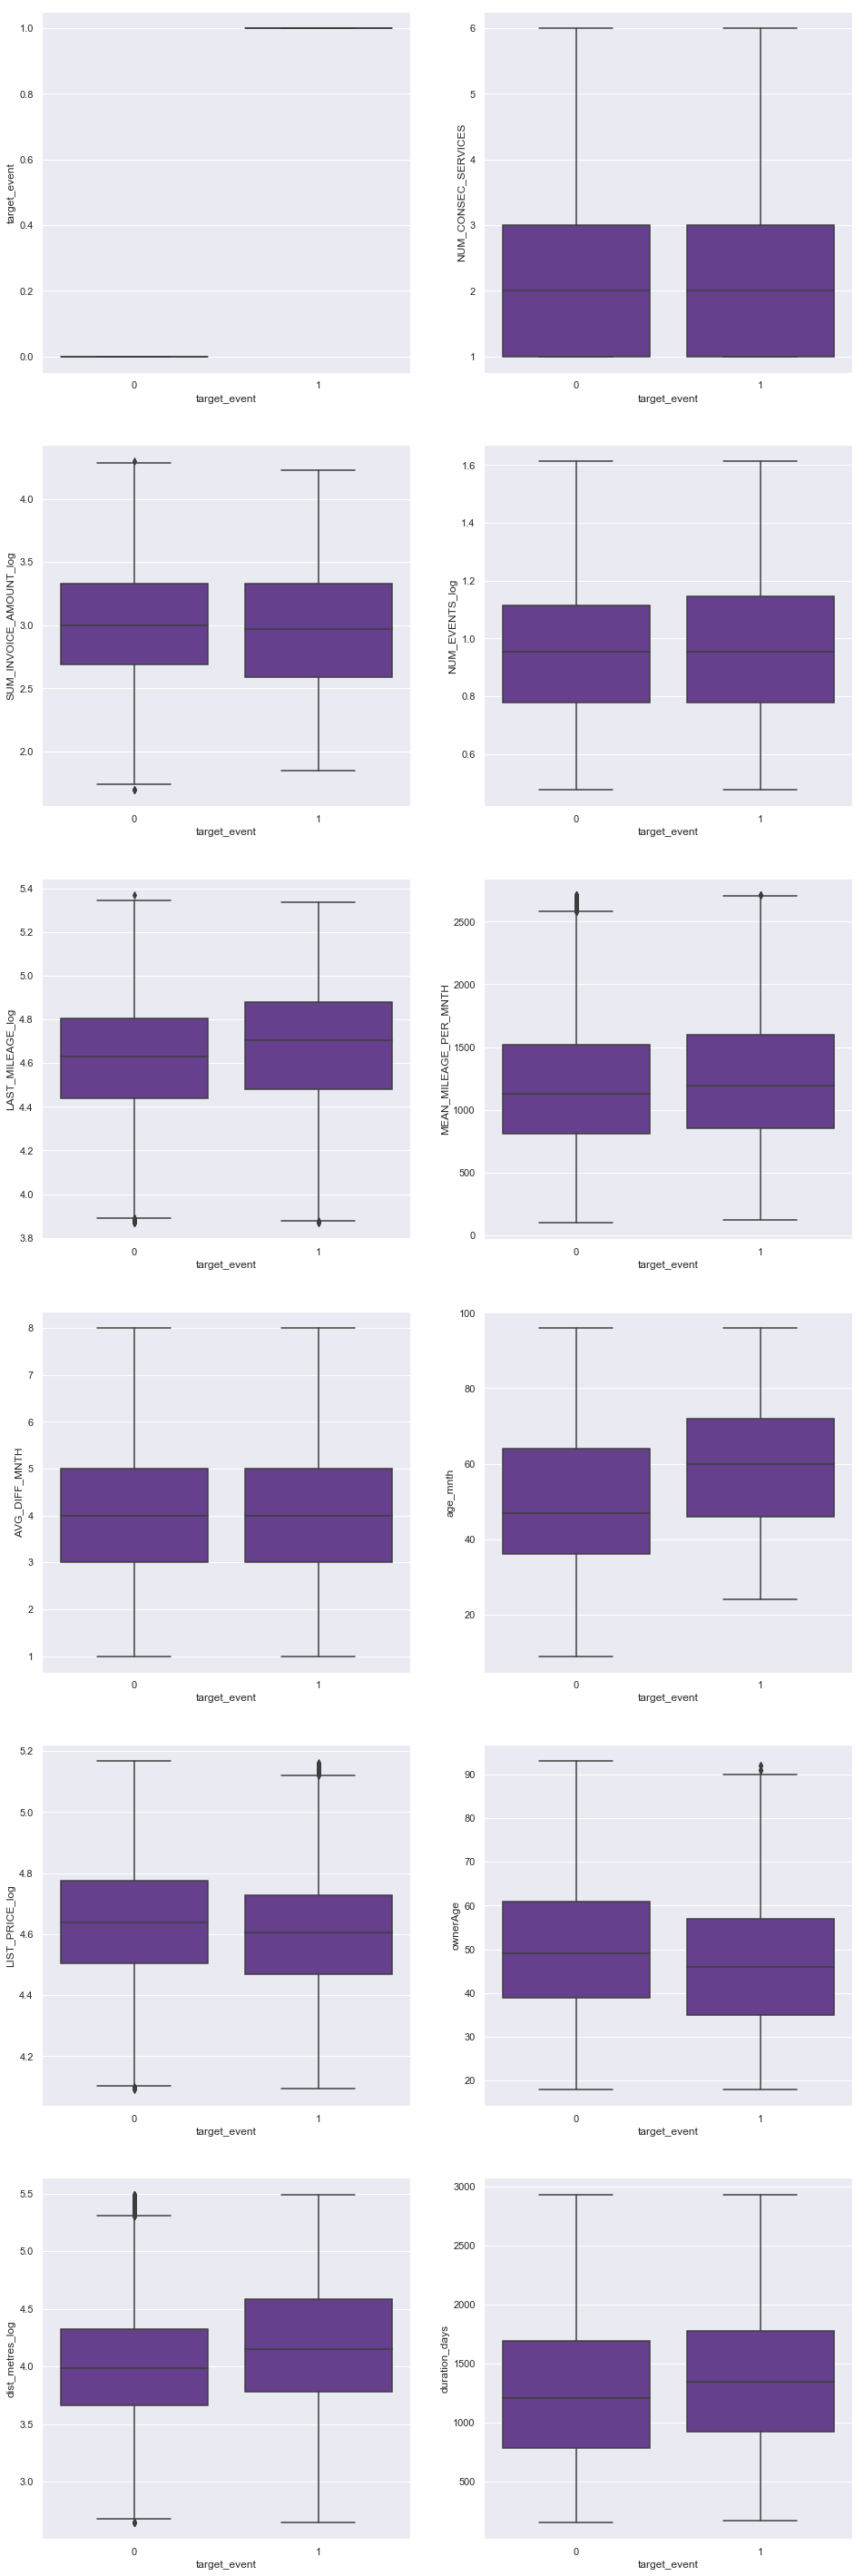

In [51]:
funEDA.corrBoxDF_numClass(churn, target='target_event', figsize=(16,60));

### Correlations between numerical variables

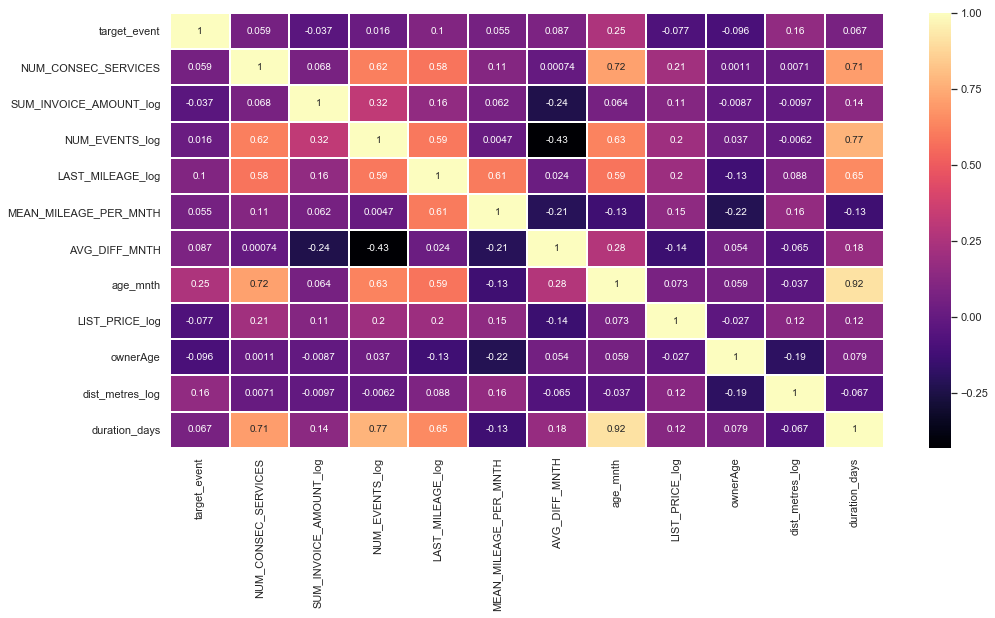

In [52]:
funEDA.corrHeatMap_num(churn, figsize=(16, 8));

**Observations:**

Generally there are no clear differences / strong correlations in regard to target variable.

- Main differences / (linear) correlations (>0.1):
    - age_mnth
    - dist_metres
    - LAST_MILEAGE (strong correlation with age_mnth)
   
   
- Lower differences / correlations (> 0.05):
    - ownerAge
    - AVG_DIFF_MNTH (correlation with age_mnth)
    - LIST_PRICE
    - durationDays (very strong correlation with age month)
    - NUM_CONSEC_SERVICES (very strong correlation with age month)
    - MEAN_MILEAGE (constructed from age_mnth and last mileage)


- No difference (< 0.05):
    - NUM_EVENTS (strong correlation with age month)
    - SUM_INVOICE_AMOUNT


**Cleaning:**
- duration_days: drop column, very high correlation to age_month
- NUM_EVENTS & SUM_INVOICE_AMOUNT: drop columns, INVOICE has more than 1/3 NaN anyway. - HAS NOT BEEN DONE.


In [53]:
for col in ['duration_days']:
    colsToDel.append(col)

churn = funCleaning.delCols(churn, colsToDel=colsToDel)

'duration_days successfully deleted'

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [10:09<00:00, 69.34s/it]


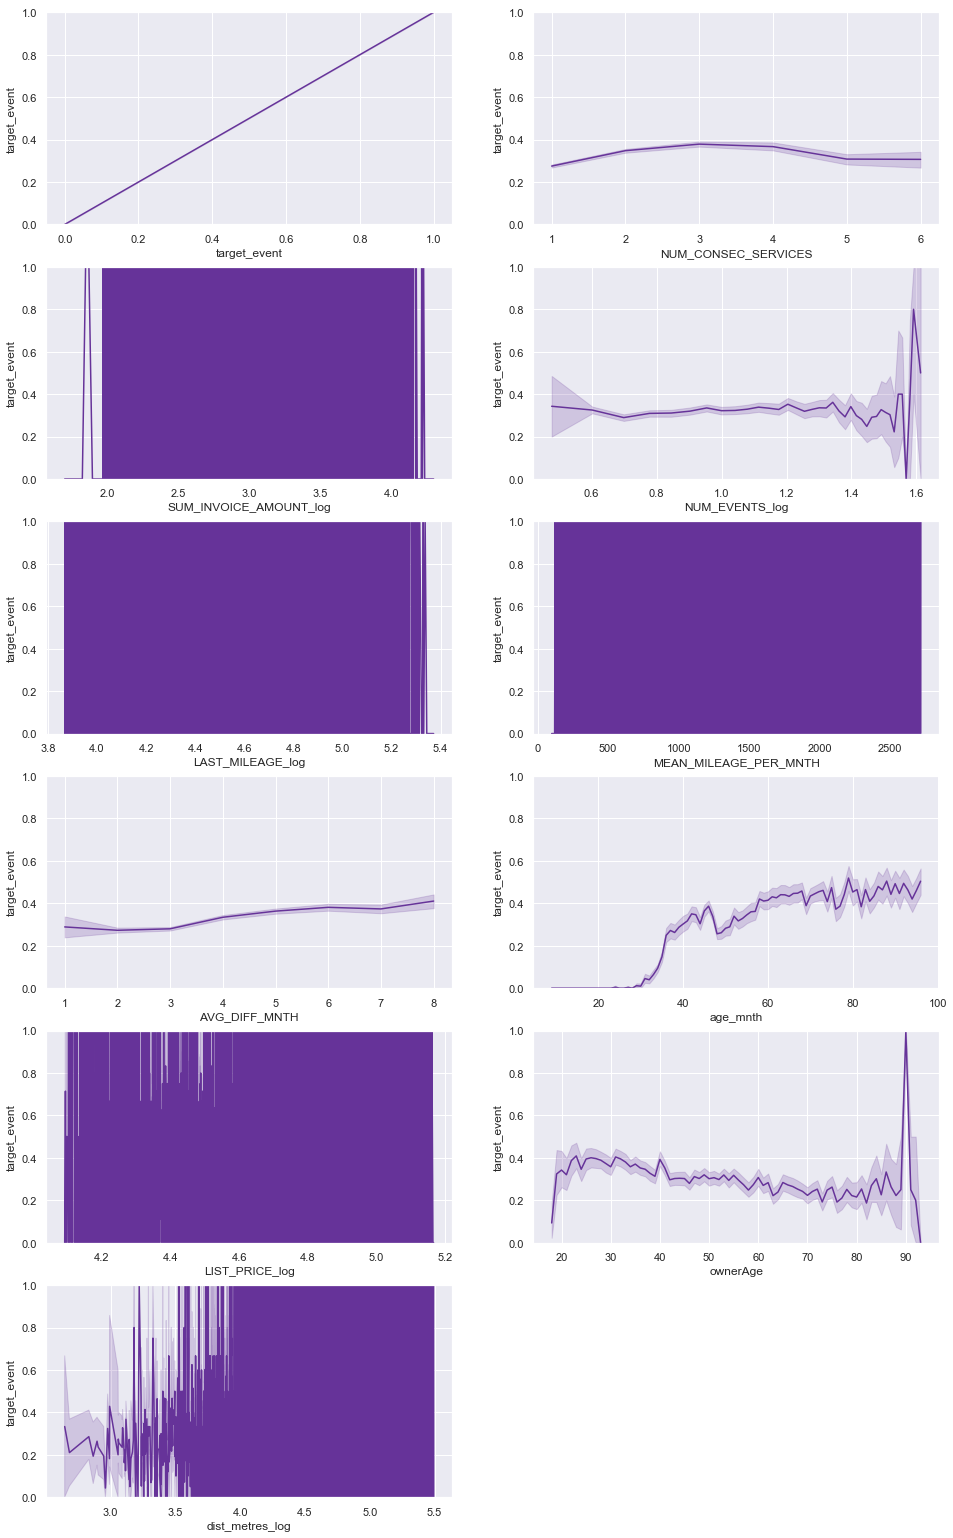

In [54]:
# one more visual check to verify the findings
funEDA.corrLineDF_numClass(churn, 'target_event', figsize=(16, 32));

### Categorical variables to 'target event'

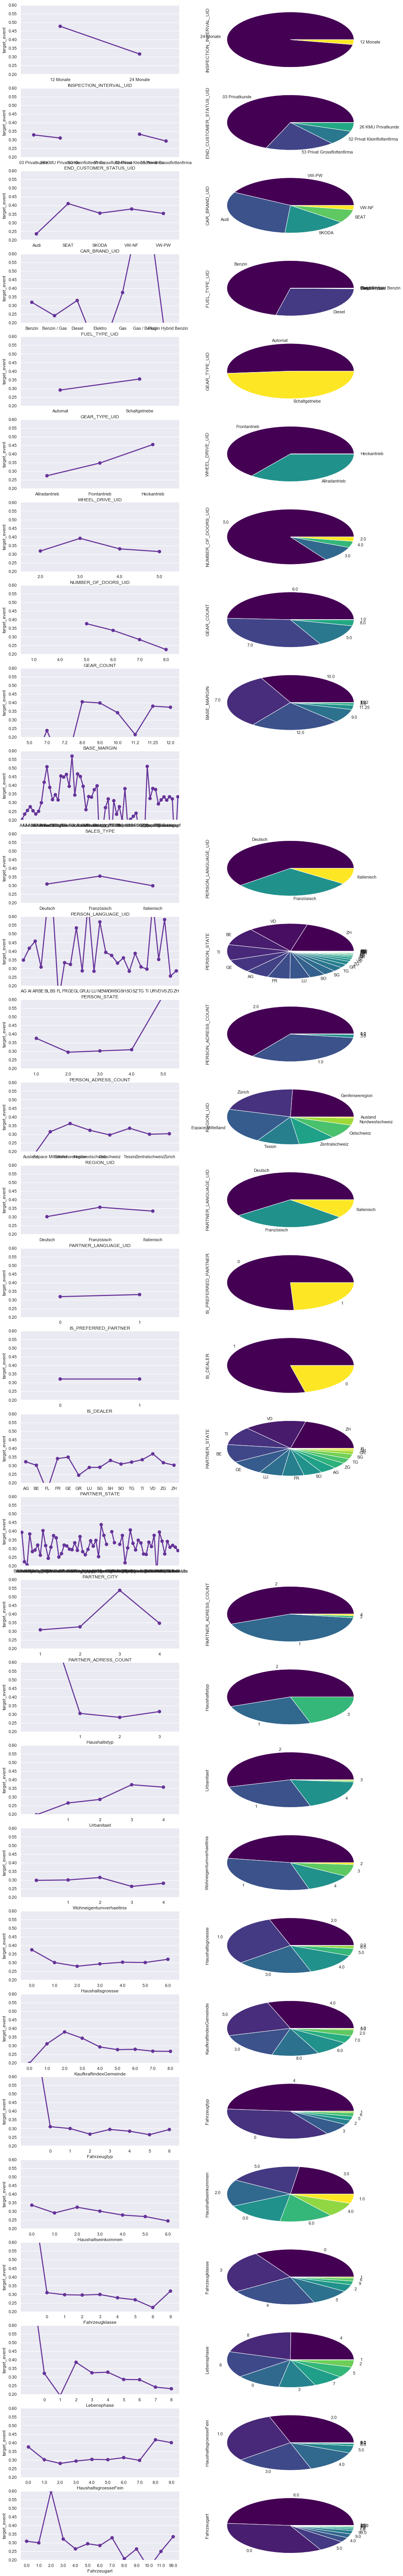

In [58]:
funEDA.corrPointDF_catClass(churn, target='target_event', figsize=(16,120), ylim=[0.2,0.6]);

**Observations:**

- Visually significant differences:
    - CAR_BRAND_UID: Audi higher than other brands
    - GEAR_TYPE_UID --> correlation with brand, age?
    - WHEEL_DRIVE_UID --> correlation with brand, age?
    - GEAR_COUNT_UID -->  correlation with brand, age?
    - BASE_MARGIN (7 much higher than 10,12) --> correlation with brand, age?
    - PERSON_LANGUAGE_UID / REGION_UID / PARTNER_LANGUAGE_UID (correlated for shure)
    
    - SALES_TYPE?
    - PARTNER_CITY? --> one outlier
    - PERSON_ADRESS_COUNT?
    

- Lower differences:
    - END_CUSTOMER_STATUS_UID
    - NUMBER_OF_DOORS_UID
    - IS_PREFERRED_PARTNER
    - Urbanitaet
    - KaufkraftindexGemeinde --> could be correlated with Region_UID
    - Haushaltseinkommen
    - Lebensphase --> could be correlated with ownerAge


- Not relevant:
    - INSPECTION_INTERVAL_UID: big difference due to low category portion
    - FUEL_TYPE_UID
    - IS_DEALER
    - PARTNER_ADRESS_COUNT
    - Haushaltstyp
    - Wohneigentumsverhältnis
    - Haushaltsgroesse
    - HaushaltsgroesseFein
    - Fahrzeugtyp
    - Fahrzeugklasse
    - Fahrzeugart
 

In [56]:
# final check
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37748 entries, 10483 to 32271
Data columns (total 42 columns):
target_event               37748 non-null int64
NUM_CONSEC_SERVICES        37748 non-null int64
SUM_INVOICE_AMOUNT_log     27191 non-null float64
NUM_EVENTS_log             37748 non-null float64
LAST_MILEAGE_log           37748 non-null float64
MEAN_MILEAGE_PER_MNTH      37748 non-null float64
AVG_DIFF_MNTH              37748 non-null int64
age_mnth                   37748 non-null int64
INSPECTION_INTERVAL_UID    37748 non-null category
LIST_PRICE_log             37747 non-null float64
END_CUSTOMER_STATUS_UID    37747 non-null category
CAR_BRAND_UID              37748 non-null category
FUEL_TYPE_UID              37747 non-null category
GEAR_TYPE_UID              37747 non-null category
WHEEL_DRIVE_UID            37747 non-null category
NUMBER_OF_DOORS_UID        36972 non-null category
GEAR_COUNT                 37747 non-null category
BASE_MARGIN                37748 non-

### Store Colums To Delete / Transform for Later Use in Data Pre-Processing Notebook

In [57]:
%store colsToDel
%store colsToCat
%store colsToLog10

Stored 'colsToDel' (list)
Stored 'colsToCat' (list)
Stored 'colsToLog10' (list)
